# The Tin Can Problem


Our boss has asked us to design a tin can that can hold $V = 20\text{in}^3$ that uses the least material. From geometry class in high school, we know that the volume of a cylinder is $\pi r^2 h$ and the quantity of tin we need is $2 \pi r^2 + 2 \pi r h$, where $r$ is the radius of the cylinder and $h$ is the height. Formulating this as an optimization problem,
$$\begin{align}
&\underset{r, h}{\min} \hspace{1.3cm} 2 \pi r^2 + 2 \pi r h \\
&\text{subject to} \quad \pi r^2 h = 20. \end{align}$$

We can also eliminate $h$ by imposing the constraint directly. In this case, we get the unconstrained optimization model
$$\underset{r}{\min} \quad 2 \pi r^2 + \frac{40}{r}.$$

Let's try to model this using JuMP in Julia.

In [26]:
import Pkg
Pkg.add("HigHS")

#Import JuMP package to build an optimization model
using JuMP
#Import HiGHS solver
using HiGHS

#Create a JuMP model that will be solved using the HiGHS solver
model = Model(HiGHS.Optimizer)
#Add the variables r and h
@variable(model, r)
@variable(model, h)
#Create our objective function and set it for minimization
@objective(model, Min, 2pi*r^2 + 2pi*r*h)
#Add our (nonlinear) constraint
@NLconstraint(model, myconstraint, pi*r^2*h == 20)
print(model)

Looks pretty good. Now let's try to solve it.

In [27]:
optimize!(model)
solution_summary(model)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        5

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.00e+01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

* Solver : Ipopt

* Status
  Termination status : LOCALLY_INFEASIBLE
  Primal status      : INFEASIBLE_POINT
  Dual status        : UNKNOWN_RESULT_STATUS
  Message from the solver:
  "Infeasible_Problem_Detected"

* Candidate solution
  Objective value      : 0.00000e+00
  Dual objective value : 0.00000e+00

* Work counters
  Solve time (sec)   : 8.99982e-03


The solver was unable to find a feasible point (one that satisfied the constraints of the problem). To figure out what went wrong, let's plot the single variable version of our problem.

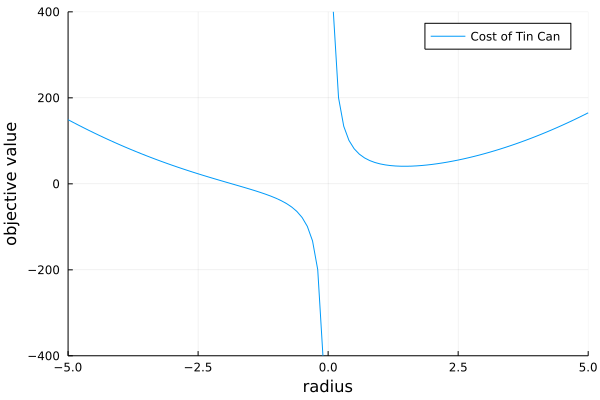

In [28]:
using Plots
gr()

radius = -5:.1:5
myobjective = 2pi*radius.^2 + 40 ./radius

plot(radius, myobjective, label = "Cost of Tin Can", xlabel = "radius", ylabel = "objective value",xlims = (-5,5), ylims = (-400,400),)

Something's clearly wrong here. Our objective function can approach $-\infty$ when the radius is negative, so the formulation has no solution right now! This is our mistake though, since a tin can with negative radius doesn't make physical sense. We need to add additional constraints to solve this.

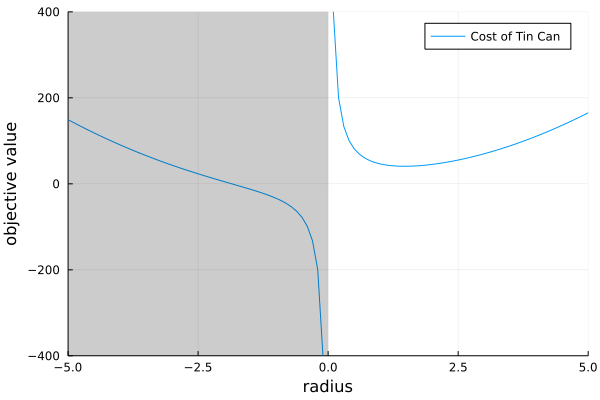

In [29]:
radius = -5:.1:5
myobjective = 2pi*radius.^2 + 40 ./radius

p = plot(radius, myobjective, label = "Cost of Tin Can", xlabel = "radius", ylabel = "objective value", xlims = (-5,5), ylims = (-400,400),)
vspan!(p,[-5,0], color = :black, alpha = 0.2, labels = "");
display(p)

If we optimize while staying out of the gray region, it looks like we can find a solution. Let's add extra constraints to our model.

In [30]:
set_lower_bound(r, 0.0)
set_lower_bound(h, 0.0)
print(model)

Our new model looks good, let's try solving it again.

In [31]:
optimize!(model)
solution_summary(model)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        5

Total number of variables............................:        2
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.2566345e-03 2.00e+01 9.37e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

* Solver : Ipopt

* Status
  Termination status : LOCALLY_SOLVED
  Primal status      : FEASIBLE_POINT
  Dual status        : FEASIBLE_POINT
  Message from the solver:
  "Solve_Succeeded"

* Candidate solution
  Objective value      : 4.07882e+01
  Dual objective value : 0.00000e+00

* Work counters
  Solve time (sec)   : 1.30000e-02


We got a solution this time! Let's find out what the optimal values for the radius and height are, as well as how much tin we need to make the can.

In [32]:
println("Optimal radius = ", value(r))
println("Optimal height = ", value(h))
println("Amount of tin needed = ", objective_value(model))

Optimal radius = 1.4710136716329476
Optimal height = 2.9420273435370032
Amount of tin needed = 40.78820010663253


To double check we did everything correctly, let's see what happens when we make and run the single variable version of our model.

In [33]:
model = Model(Ipopt.Optimizer)
@variable(model, r >= 0)
@NLobjective(model, Min, 2pi*r^2 + 40/r)
print(model)
optimize!(model)
println("Optimal radius = ", value(r))
println("Optimal height = ", 20/(pi*value(r)^2))
println(objective_value(model))

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:        1
                     variables with only lower bounds:        1
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.0000046e+03 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

We got nearly the same output! Let's see what the solution looks like visually on the plot we made earlier.

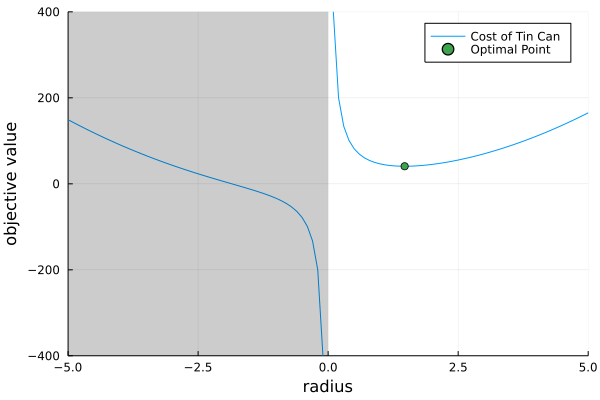

In [34]:
radius = -5:.1:5
myobjective = 2pi*radius.^2 + 40 ./radius

p = plot(radius, myobjective, label = "Cost of Tin Can", xlabel = "radius", ylabel = "objective value", xlims = (-5,5), ylims = (-400,400),)
vspan!(p,[-5,0], color = :black, alpha = 0.2, labels = "");
plot!(p,[value(r)],[objective_value(model)], seriestype = :scatter, label = "Optimal Point")
display(p)